In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
from sklearn.feature_selection import mutual_info_regression

In [35]:
def read_dataset(name='data/factor_capacidad_conjunto.csv',data='solar'):
    df = pd.read_csv(name,index_col=0,parse_dates=True)
    df.index.freq = 'H'
    return df[data]

In [36]:
def new_corr_coef_series(s_x, s_y):
    """
    s_x: pd.Series, np.array
    """
    assert len(s_x)==len(s_y)
    n = len(s_x)
    df = pd.DataFrame({'x':s_x, 'y':s_y})
    # df = df.dropna()
    df = df.sort_values(by='x', ascending=True)
    rank = df['y'].rank(method='min')
    coef = 1 - 3*sum(abs(rank-rank.shift(1))[1:])/(n**2-1)
    return coef

def new_corr_coef(df, x='x', y='y'):
    """
    s_x: pd.Series, np.array
    """
    n = len(df)
    df = df.sort_values(by=x, ascending=True)
    rank = df[y].rank(method='min')
    coef = 1 - 3*sum(abs(rank-rank.shift(1))[1:])/(n**2-1)
    return coef

## ACF PACF

In [3]:
import seaborn as sns
s_eolica = read_dataset(data='eolica')

<Axes: xlabel='eolica', ylabel='Density'>

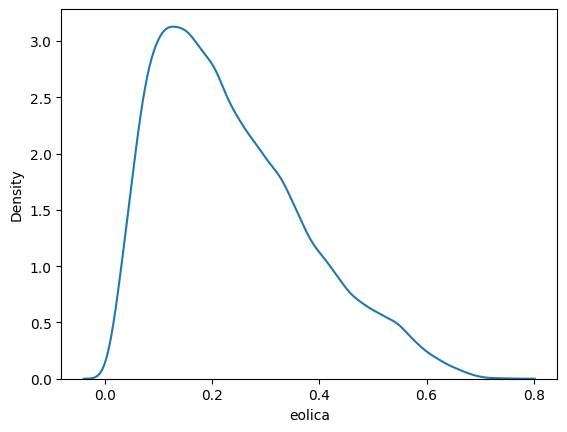

In [10]:
sns.kdeplot(s_eolica)

<Axes: xlabel='eolica', ylabel='Density'>

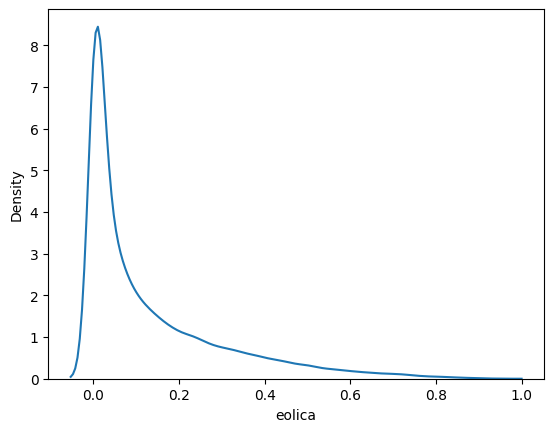

In [17]:
sns.kdeplot((s_eolica-1)**12)

(array([ 8602., 18474., 16921., 13076.,  9742.,  6007.,  3739.,  2290.,
          693.,    63.]),
 array([0.00453212, 0.07988661, 0.15524109, 0.23059558, 0.30595006,
        0.38130455, 0.45665903, 0.53201352, 0.607368  , 0.68272249,
        0.75807697]),
 <BarContainer object of 10 artists>)

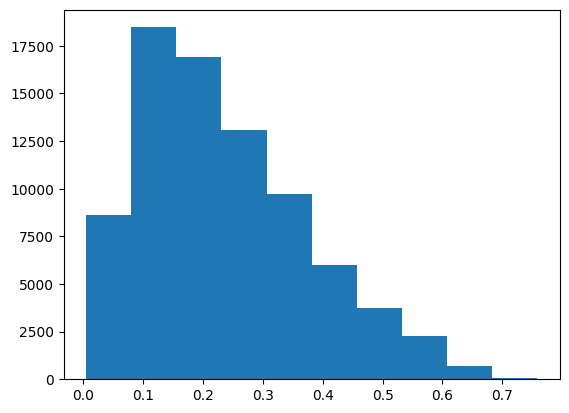

In [4]:
plt.hist(s_eolica)

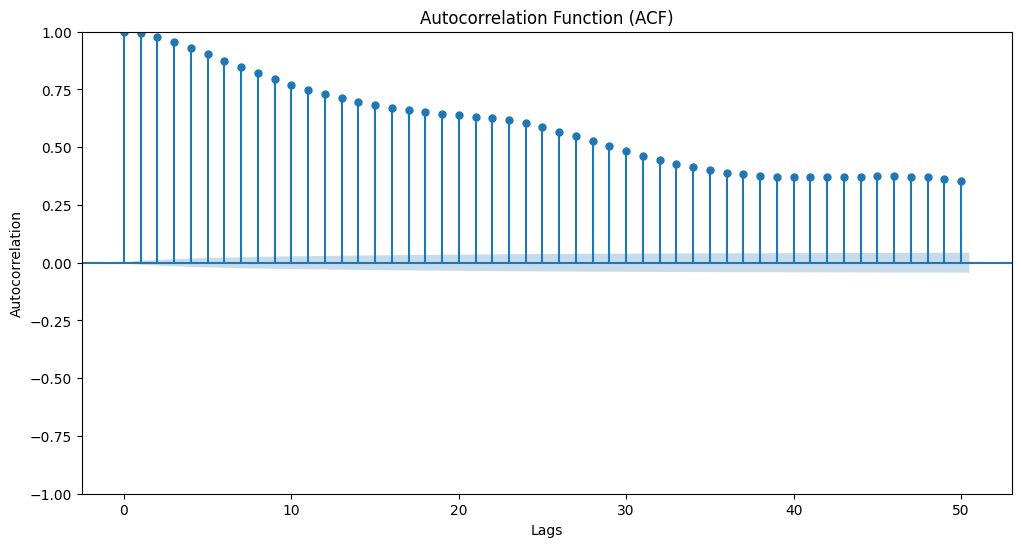

In [4]:
plt.figure(figsize=(12, 6))
plot_acf(Y_df, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

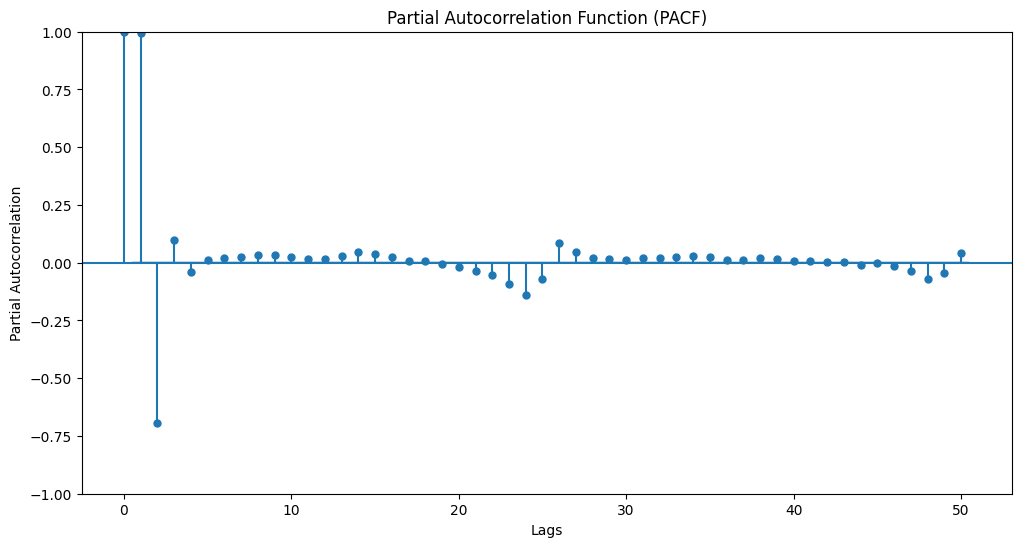

In [5]:
plt.figure(figsize=(12, 6))
plot_pacf(Y_df, lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Lagged correlation

In [8]:
def calc_lcf(series_org, series_lag, n_lags=24*3):
    assert len(series_org) == len(series_lag)
    rhos = []
    xis = []
    mis = []
    for lag in range(n_lags + 1):
        shifted_series = series_lag.shift(lag)
        rho = series_org.corr(shifted_series)
        df = pd.DataFrame({'x':shifted_series, 'y':series_org})
        df = df.dropna()
        xi = new_corr_coef(df)
        mi = mutual_info_regression(df[['x']], df['y'])
        rhos.append(rho)
        xis.append(xi)
        mis.append(mi)
    return rhos, xis, mis

s_eolica = read_dataset(data='eolica')
s_solar = read_dataset(data='solar')
t1 = time()
solar2solar = calc_lcf(s_solar, s_solar)
print(f"solar2solar: {time()-t1:.1f}")
t1 = time()
solar2eolica = calc_lcf(s_solar, s_eolica)
print(f"solar2eolica: {time()-t1:.1f}")
t1 = time()
eolica2eolica = calc_lcf(s_eolica, s_eolica)
print(f"eolica2eolica: {time()-t1:.1f}")
t1 = time()
eolica2solar = calc_lcf(s_eolica, s_solar)
print(f"eolica2solar: {time()-t1:.1f}")

solar2solar: 82.2
solar2eolica: 96.8
eolica2eolica: 103.7
eolica2solar: 99.5


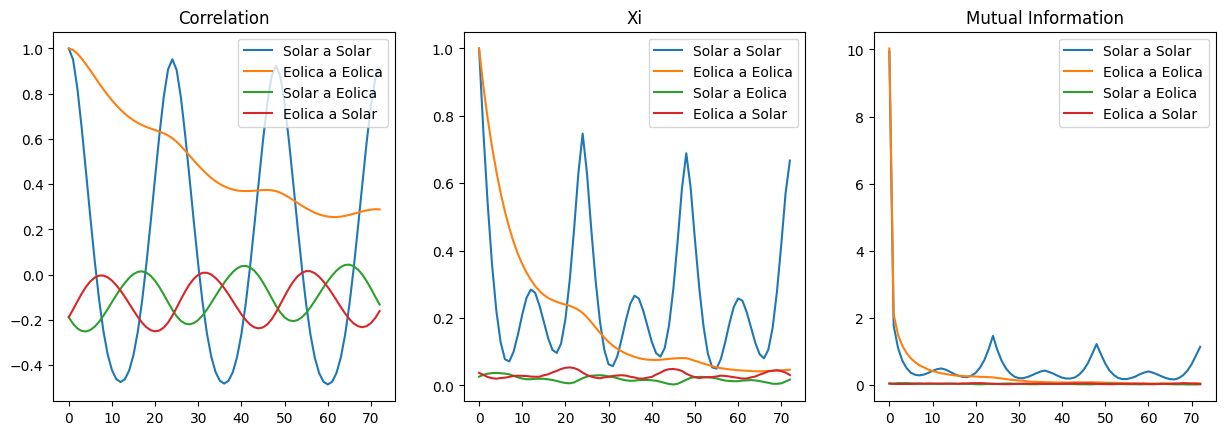

In [9]:
fig, ax = plt.subplots(1,3)
ax[0].set_title('Correlation')
ax[1].set_title('Xi')
ax[2].set_title('Mutual Information')
fig.set_figwidth(15)
for i in range(3):
    ax[i].plot(solar2solar[i])
    ax[i].plot(eolica2eolica[i])
    ax[i].plot(solar2eolica[i])
    ax[i].plot(eolica2solar[i])
    ax[i].legend(['Solar a Solar', 'Eolica a Eolica', 'Solar a Eolica', 'Eolica a Solar'])

plt.show()

### Lagged correlation hourly

In [29]:
def calc_lcf(series_org, series_lag, n_lags=30*2, hour=0):
    assert len(series_org) == len(series_lag)
    series_org = series_org[series_org.index.hour==hour]
    series_lag = series_lag[series_lag.index.hour==hour]
    rhos = []
    xis = []
    mis = []
    for lag in range(n_lags + 1):
        shifted_series = series_lag.shift(lag)
        rho = series_org.corr(shifted_series)
        df = pd.DataFrame({'x':shifted_series, 'y':series_org})
        df = df.dropna()
        xi = new_corr_coef(df)
        mi = mutual_info_regression(df[['x']], df['y'])
        rhos.append(rho)
        xis.append(xi)
        mis.append(mi)
    return rhos, xis, mis


solar2solar = []
solar2eolica = []
eolica2eolica = []
eolica2solar = []
for i in range(24):
    t1 = time()
    solar2solar.append(calc_lcf(s_solar, s_solar, hour=i))
    solar2eolica.append(calc_lcf(s_solar, s_eolica, hour=i))
    eolica2eolica.append(calc_lcf(s_eolica, s_eolica, hour=i))
    eolica2solar.append(calc_lcf(s_eolica, s_solar, hour=i))
    print(f"Hora {i}: {time()-t1:.1f}")

Hora 0: 39.5
Hora 1: 25.3
Hora 2: 36.6
Hora 3: 45.5
Hora 4: 40.8
Hora 5: 34.9
Hora 6: 36.4
Hora 7: 50.8
Hora 8: 67.4
Hora 9: 37.1
Hora 10: 27.0
Hora 11: 40.4
Hora 12: 72.0
Hora 13: 29.5
Hora 14: 26.8
Hora 15: 28.0
Hora 16: 29.4
Hora 17: 29.5
Hora 18: 27.6
Hora 19: 31.8
Hora 20: 40.6
Hora 21: 36.8
Hora 22: 39.5
Hora 23: 25.2


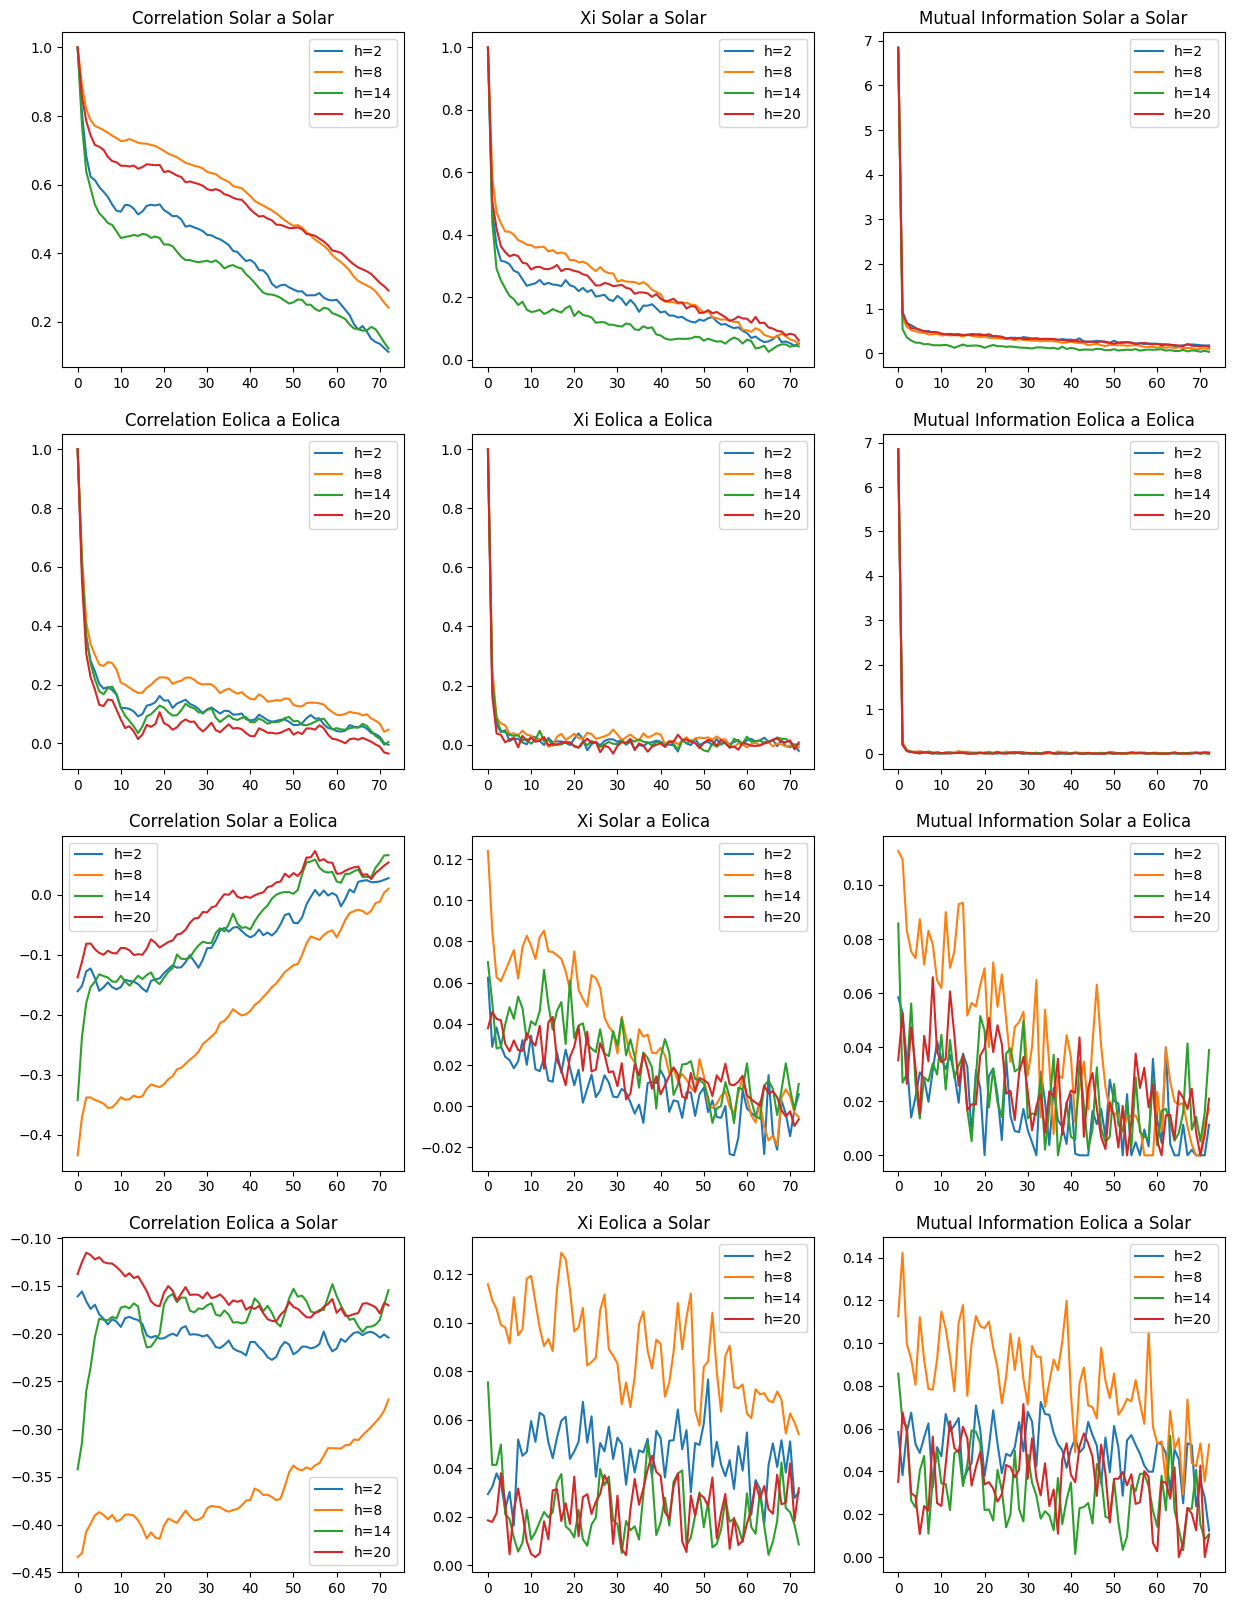

In [30]:
data = { # REducir 14 días de lag
    'Solar a Solar':solar2solar,
    'Eolica a Eolica':eolica2eolica,
    'Solar a Eolica':solar2eolica,
    'Eolica a Solar':eolica2solar,
}
metrics=['Correlation','Xi','Mutual Information']
hours = [2,8,14,20]
SIDE=5
fig, ax = plt.subplots(len(data.keys()),len(metrics))
fig.set_figwidth(SIDE*len(metrics))
fig.set_figheight(SIDE*len(data.keys()))
for m in range(len(metrics)):
    for i,k in enumerate(data.keys()):
        legend=[]
        for h in hours:
            ax[i][m].plot(data[k][h][m])
            legend.append(f'h={h}')
        ax[i][m].legend(legend)
        title = f'{metrics[m]} {k}'
        ax[i][m].set_title(title)
plt.show()

## Monthly correlation

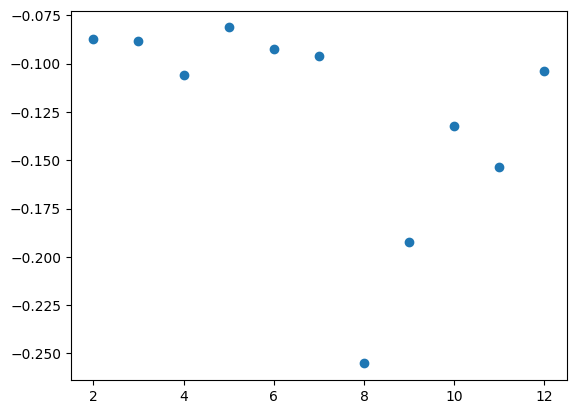

In [41]:
corrs = []
for i in range(12):
     s1 = s_solar[s_solar.index.month==i]
     s2 = s_eolica[s_eolica.index.month==i]
     corrs.append(s1.corr(s2))

plt.scatter(list(range(1,12+1)),corrs)

In [31]:
def calc_lcf(series_org, series_lag, n_lags=24*3, month=0):
    assert len(series_org) == len(series_lag)
    series_org = series_org[series_org.index.month==month]
    series_lag = series_lag[series_lag.index.month==month]
    rhos = []
    xis = []
    mis = []
    for lag in range(n_lags + 1):
        shifted_series = series_lag.shift(lag)
        rho = series_org.corr(shifted_series)
        df = pd.DataFrame({'x':shifted_series, 'y':series_org})
        df = df.dropna()
        xi = new_corr_coef(df)
        mi = mutual_info_regression(df[['x']], df['y'])
        rhos.append(rho)
        xis.append(xi)
        mis.append(mi)
    return rhos, xis, mis


solar2solar = []
solar2eolica = []
eolica2eolica = []
eolica2solar = []
for i in range(1,12+1):
    solar2solar.append(calc_lcf(s_solar, s_solar, month=i))
    solar2eolica.append(calc_lcf(s_solar, s_eolica, month=i))
    eolica2eolica.append(calc_lcf(s_eolica, s_eolica, month=i))
    eolica2solar.append(calc_lcf(s_eolica, s_solar, month=i))

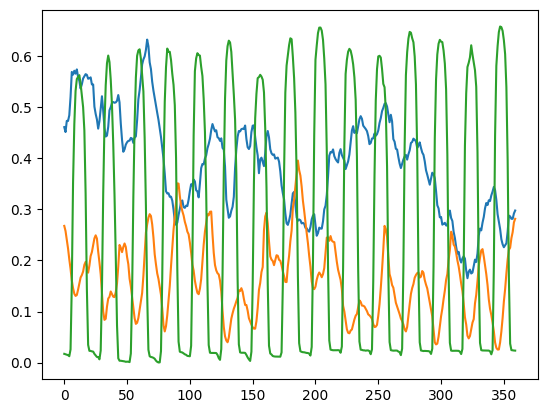

In [41]:
s_eolica = read_dataset(data='eolica')
s_solar = read_dataset(data='solar')

s = s_eolica[s_eolica.index.month==1]
plt.plot(s[-30*12:].to_numpy())
s = s_eolica[s_eolica.index.month==7]
plt.plot(s[-30*12:].to_numpy())
s = s_solar[s_solar.index.month==7]
plt.plot(s[-30*12:].to_numpy())

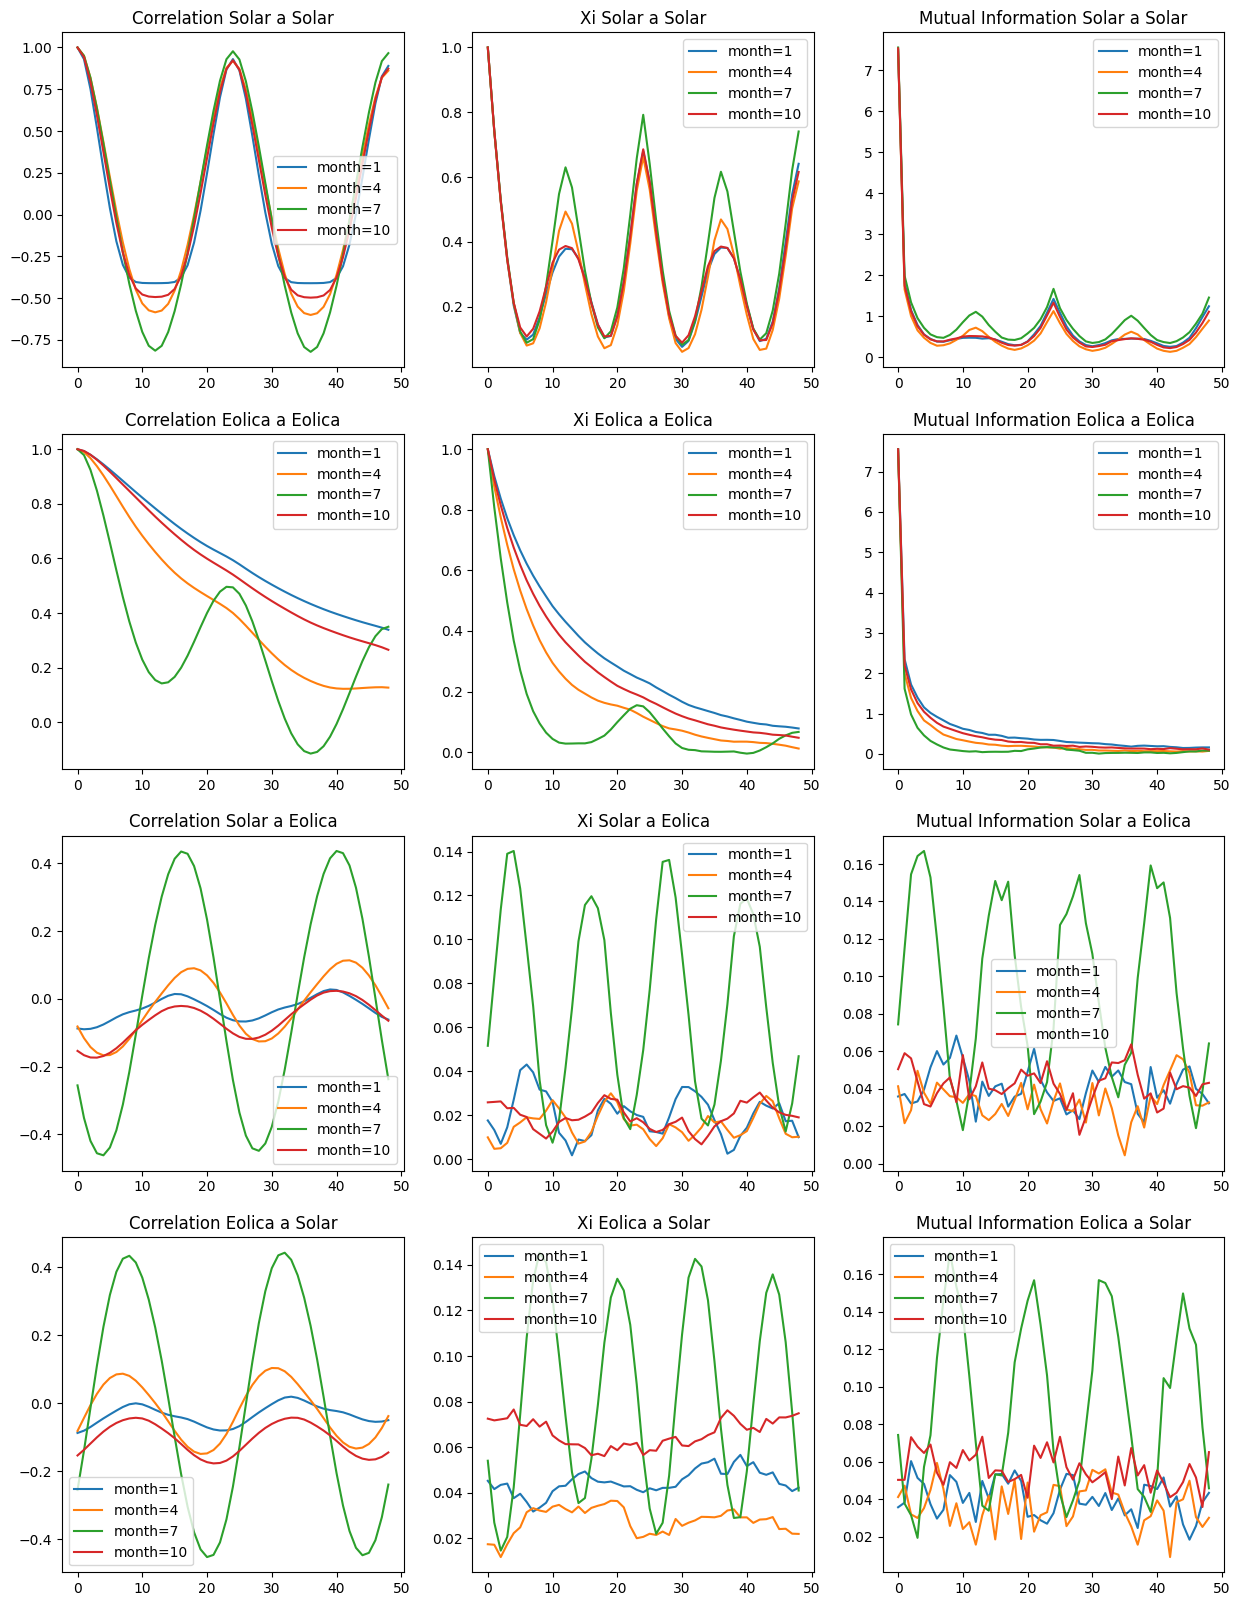

In [33]:
data = {
    'Solar a Solar':solar2solar,
    'Eolica a Eolica':eolica2eolica,
    'Solar a Eolica':solar2eolica,
    'Eolica a Solar':eolica2solar,
}
metrics=['Correlation','Xi','Mutual Information']
months = [1,4,7,10]
SIDE=5
fig, ax = plt.subplots(len(data.keys()),len(metrics))
fig.set_figwidth(SIDE*len(metrics))
fig.set_figheight(SIDE*len(data.keys()))
for m in range(len(metrics)):
    for i,k in enumerate(data.keys()):
        legend=[]
        for h in months:
            ax[i][m].plot(data[k][h-1][m])
            legend.append(f'month={h}')
        ax[i][m].legend(legend)
        title = f'{metrics[m]} {k}'
        ax[i][m].set_title(title)
plt.show()

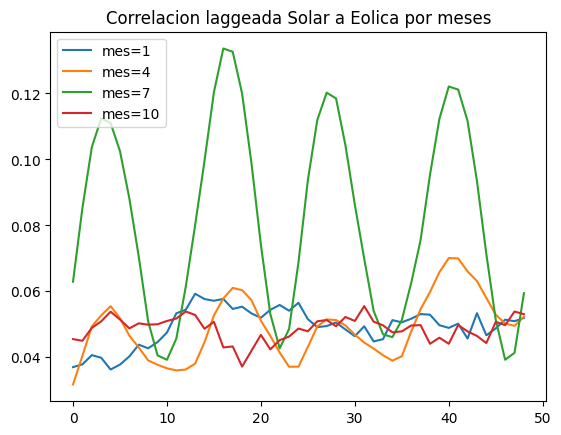

In [26]:
legend = []
hours = [1,4,7,10]
for i in hours:
    plt.plot(solar2eolica[i])
    legend.append(f'mes={i}')
plt.title('Correlacion laggeada Solar a Eolica por meses')
plt.legend(legend)

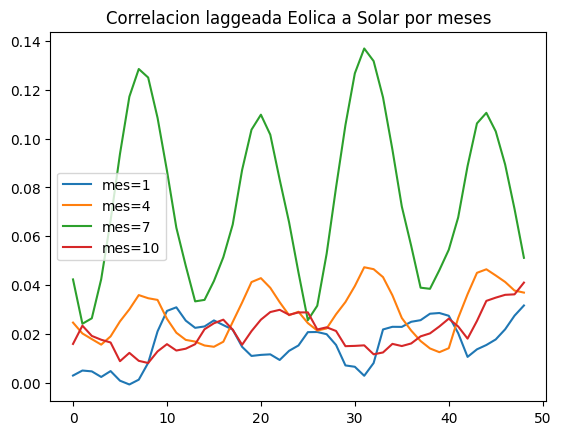

In [27]:
legend = []
hours = [1,4,7,10]
for i in hours:
    plt.plot(eolica2solar[i])
    legend.append(f'mes={i}')
plt.title('Correlacion laggeada Eolica a Solar por meses')
plt.legend(legend)